# Project 2: Customer Exit Prediction

# Introduction:

*   In this project, you will predict whether a customer will exit (CustomerExit) based on various service and demographic features.
*   You will conduct data exploration, preprocessing, and train machine learning models to predict customer exit.
*   Finally, you'll evaluate the models using classification metrics.

**Datasets Locations and Names:** Canvas -> Modules -> Week 10 -> Dataset -> "customer_exit.csv".

Please save your Google Colab project as FirstName_LastName_Project2.ipynb and submit (upload) your source code to Canvas.

# Dataset Description:

* **ServiceFee:** Monthly fee the customer pays.
* **SubscriptionType:** Type of contract (e.g., month-to-month, yearly).
* **MembershipDuration**: How many months the customer has been with the service.
* **CumulativeCharges:** Total amount billed to the customer.
* **Age:** Age of the customer.
* **Gender:** Gender of the customer.
* **CustomerExit:** The target variable, indicating whether the customer left (1 = exit, 0 = stays).

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectPercentile, VarianceThreshold, f_regression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import time
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("./customer_exit.csv")
df

,age,gender,membership_duration,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,cumulative_charges,last_interaction,customer_exit
0,18,Male,5.0,20.0,1.0,3.0,Basic,Quarterly,421.00,15.0,1.0
1,33,Female,38.0,28.0,7.0,8.0,Premium,Quarterly,577.00,11.0,0.0
2,18,Male,16.0,21.0,1.0,11.0,Basic,Quarterly,792.85,6.0,0.0
3,49,Female,57.0,12.0,2.0,7.0,Premium,Quarterly,590.65,7.0,0.0
4,22,Female,26.0,2.0,4.0,23.0,Standard,Monthly,811.00,14.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
505201,38,Female,44.0,18.0,2.0,13.0,Premium,Annual,717.39,3.0,0.0
505202,38,Male,44.0,14.0,3.0,13.0,Basic,Annual,995.38,8.0,0.0
505203,18,Female,9.0,4.0,10.0,12.0,Basic,Monthly,979.00,8.0,1.0
505204,23,Female,27.0,5.0,10.0,20.0,Premium,Annual,824.00,1.0,1.0


In [5]:
df.describe()

,age,membership_duration,usage_frequency,support_calls,payment_delay,cumulative_charges,last_interaction,customer_exit
count,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000
mean,29.796477,31.350435,15.714825,3.833317,13.496843,620.072766,14.610581,0.555203
std,11.465629,17.237482,8.619323,3.133603,8.451187,245.319256,8.608286,0.496944
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,18.000000,16.000000,8.000000,1.000000,6.000000,446.000000,7.000000,0.000000
50%,27.000000,32.000000,16.000000,3.000000,13.000000,648.900000,14.000000,1.000000
75%,40.000000,46.000000,23.000000,6.000000,20.000000,824.000000,22.000000,1.000000
max,52.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


# Task 1: Exploratory Data Analysis (EDA)
* Visualize the distribution of the target variable (`CustomerExit`).
* Create scatter plots or histograms to explore relationships between features.
* Check for missing values.

In [4]:
def plot_dual_histogram(data, value_column, category_column, bins=10, alpha=0.6,  partitions=None, ax=None):

    # Get or create axis
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 6))
    
    # Get unique categories
    categories = data[category_column].unique()
    if len(categories) != 2:
        raise ValueError("This function expects exactly two categories")
    
    # Calculate bin edges based on all data
    min_val = data[value_column].min()
    max_val = data[value_column].max()
    bin_edges = np.linspace(min_val, max_val, bins + 1)
    
    # Calculate bin widths
    bin_width = (max_val - min_val) / bins
    bar_width = bin_width * 0.4  # Make bars slightly narrower than bin width


    if len(partitions) != len(categories):
        partitions = categories
    
    # Plot histogram for each category
    for i, category in enumerate(categories):
        category_data = data[data[category_column] == category][value_column]
        
        # Calculate histogram values
        hist, _ = np.histogram(category_data, bins=bin_edges)
        
        # Calculate bar positions (shift bars left/right based on category)
        bar_positions = bin_edges[:-1] + (i * bar_width) + (bin_width * 0.1)
        
        # Plot bars
        ax.bar(bar_positions, hist, width=bar_width, alpha=alpha,
                label=f'Category {partitions[i]}')
    
    ax.set_xlabel(value_column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {value_column} by {category_column}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax


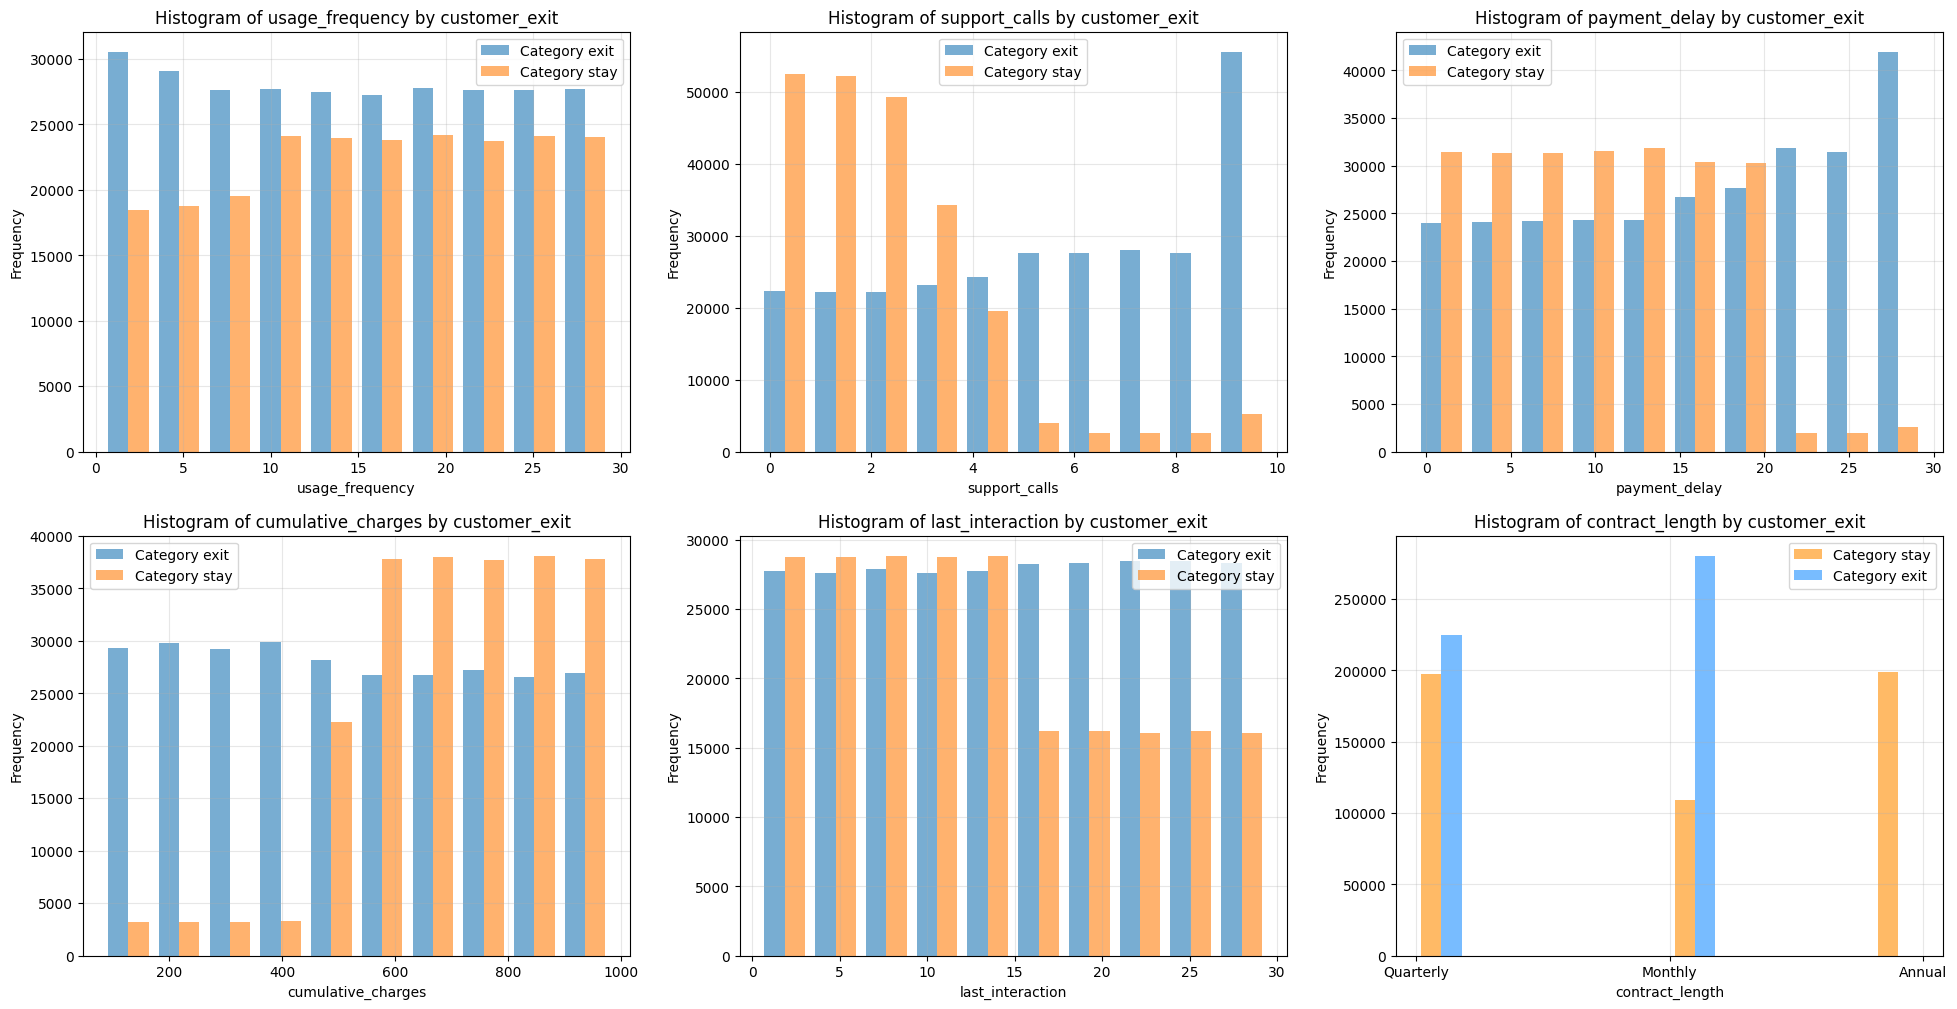

In [33]:
histogram_cols = ['usage_frequency', 'support_calls', 'payment_delay', 'cumulative_charges', 'last_interaction']
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(24, 12))
ax = ax.flatten()
for i, col in enumerate(histogram_cols):
    plot_dual_histogram(df, col, 'customer_exit', partitions=['exit', 'stay'], ax=ax[i])

ax[5].hist(df[['contract_length', 'customer_exit']], alpha=0.6, label=['Category stay','Category exit'], color=['darkorange', 'dodgerblue'])
ax[5].set_xlabel('contract_length')
ax[5].set_ylabel('Frequency')
ax[5].set_title('Histogram of contract_length by customer_exit')
ax[5].legend()
ax[5].grid(True, alpha=0.3)

In [36]:
def plot_dual_scatter(data, x_column, y_column, category_column, ax=None):
    # Get or create axis
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 6))

    ax.scatter(data[x_column], data[y_column], c=data[category_column], cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkorange","dodgerblue"]), alpha=0.6)
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_title(f'{x_column} by {y_column}')

    return ax

In [27]:
df.describe()

,age,membership_duration,usage_frequency,support_calls,payment_delay,cumulative_charges,last_interaction,customer_exit
count,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000
mean,29.796477,31.350435,15.714825,3.833317,13.496843,620.072766,14.610581,0.555203
std,11.465629,17.237482,8.619323,3.133603,8.451187,245.319256,8.608286,0.496944
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,18.000000,16.000000,8.000000,1.000000,6.000000,446.000000,7.000000,0.000000
50%,27.000000,32.000000,16.000000,3.000000,13.000000,648.900000,14.000000,1.000000
75%,40.000000,46.000000,23.000000,6.000000,20.000000,824.000000,22.000000,1.000000
max,52.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


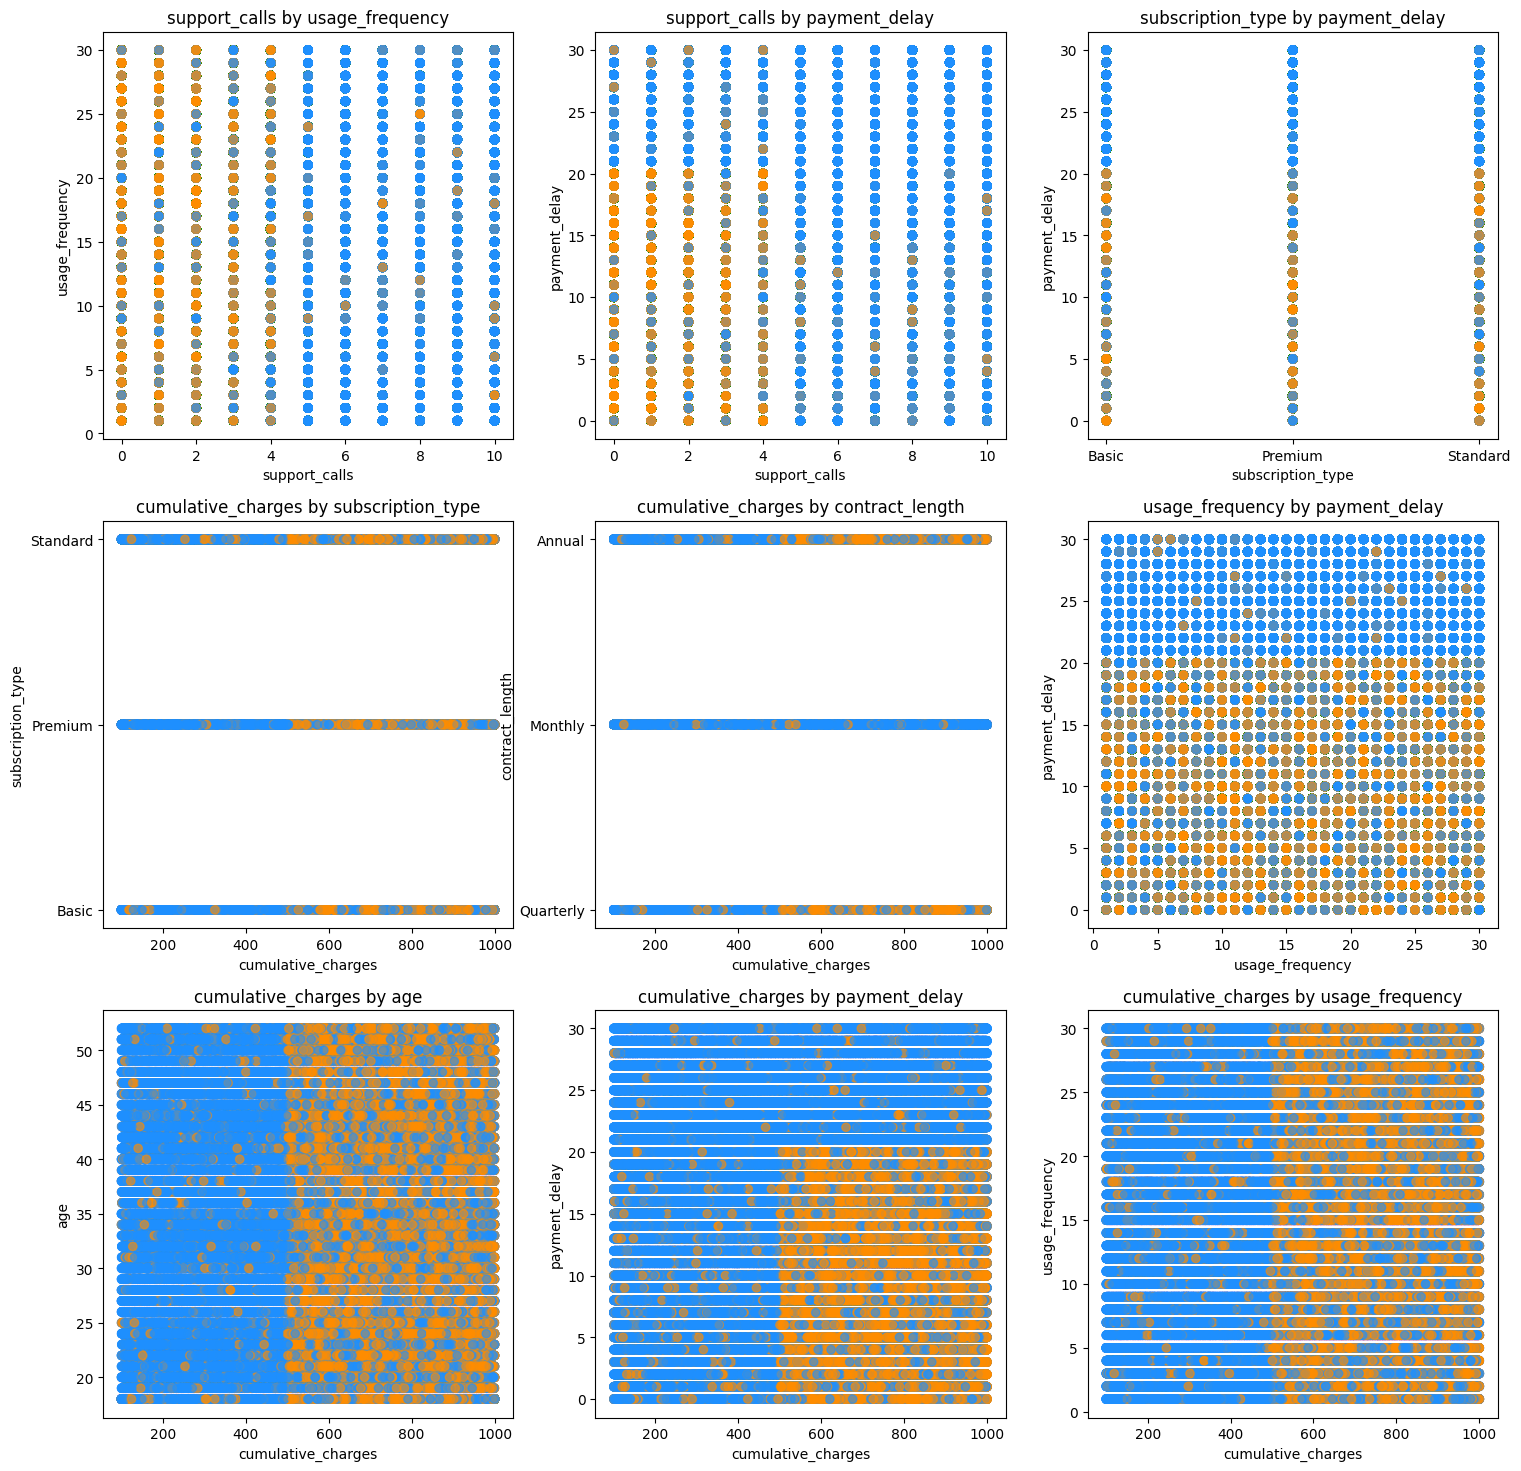

In [37]:
fig, axes = plt.subplots(figsize=(18,18), ncols=3, nrows=3)
axes = axes.flatten()
plot_dual_scatter(df, 'support_calls', 'usage_frequency', 'customer_exit', ax=axes[0])
plot_dual_scatter(df, 'support_calls', 'payment_delay', 'customer_exit', ax=axes[1])
plot_dual_scatter(df, 'subscription_type', 'payment_delay', 'customer_exit', ax=axes[2])
plot_dual_scatter(df, 'cumulative_charges', 'subscription_type', 'customer_exit', ax=axes[3])
plot_dual_scatter(df, 'cumulative_charges', 'contract_length', 'customer_exit', ax=axes[4])
plot_dual_scatter(df, 'usage_frequency', 'payment_delay', 'customer_exit', ax=axes[5])
plot_dual_scatter(df, 'cumulative_charges', 'age', 'customer_exit', ax=axes[6])
plot_dual_scatter(df, 'cumulative_charges', 'payment_delay', 'customer_exit', ax=axes[7])
plot_dual_scatter(df, 'cumulative_charges', 'usage_frequency', 'customer_exit', ax=axes[8])
plt.show()

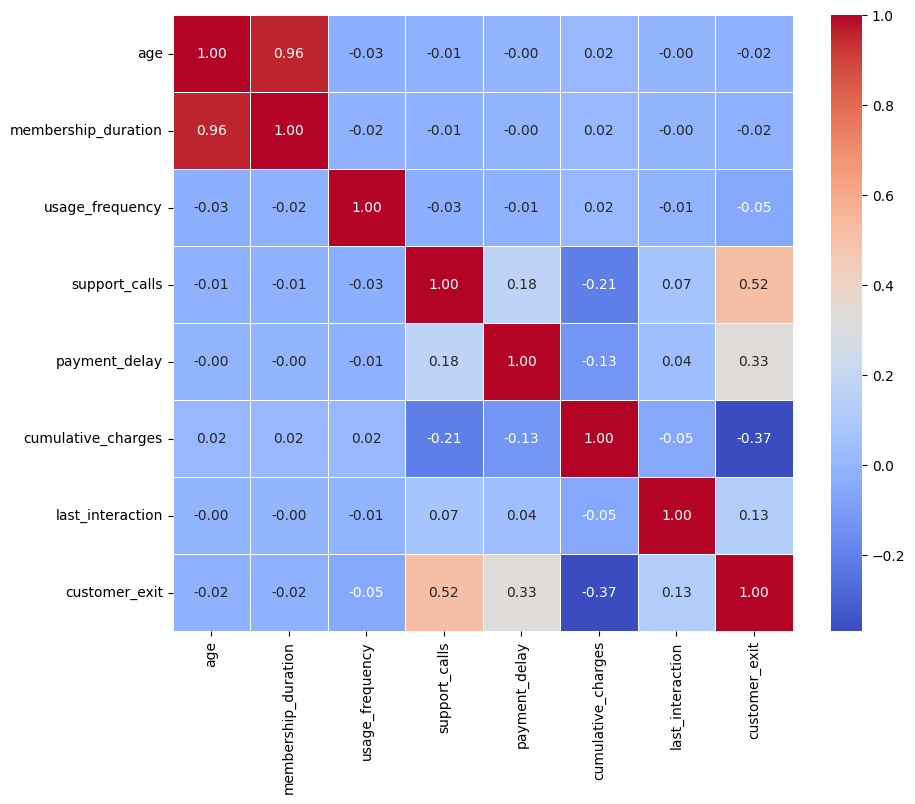

,customer_exit,Abs
customer_exit,1.000000,1.000000
support_calls,0.516283,0.516283
cumulative_charges,-0.369682,0.369682
payment_delay,0.329785,0.329785
last_interaction,0.127150,0.127150
usage_frequency,-0.053263,0.053263
age,-0.021603,0.021603
membership_duration,-0.021308,0.021308


In [30]:
plt.figure(figsize=(10,8))
corr_matrix = df.select_dtypes(include = ['float64', 'int64']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidth=0.5)
plt.show()

estimated_corr = pd.DataFrame(corr_matrix[-1:]).T
estimated_corr["Abs"] = estimated_corr["customer_exit"].abs()
estimated_corr = estimated_corr.sort_values(by="Abs", ascending=False)
estimated_corr

# Task 2: Data Preprocessing with Pipelines and Feature Extraction
* Use Pipeline for handling missing values, scaling, and feature extraction.
* Use ColumnTransformer for applying different transformations to numeric and categorical features.

In [4]:
cat_cols = ['gender', 'subscription_type', 'contract_length']
num_cols = ['age', 'membership_duration', 'usage_frequency', 'support_calls', 'payment_delay', 'cumulative_charges', 'last_interaction']

numeric_preprocessor_std = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_preprocessor = Pipeline([
    ('imputer', SimpleImputer(fill_value='missing', strategy='constant')),
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ('categorical', categorical_preprocessor, cat_cols),
    ('numerical', numeric_preprocessor_std, num_cols)
])

pipe = Pipeline([
    ('column_transformer', preprocessor),
    # Making sure that features have some variance
    ('variancethreshold', VarianceThreshold(threshold=0.0)),
    ('selectpercentile', SelectPercentile(f_regression, percentile=90)),
    # Feature Extraction
    ('pca', PCA()),
])

pipe

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['gender',
                                                   'subscription_type',
                                                   'contract_length']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'membership_duration',
                                                   'usage_frequency',
                                                   'support_calls',
                                                   'payment_delay',
                                                   'cumulative_charges',
                                                   'last_interaction'])])),
                ('variancethreshold', VarianceThreshold()),
                ('selectpercentile',
                 SelectPercentile(percentile=90,
                                  score_func=<function f_regression at 0x0000026EBAB50B80>)),
                ('pca', PCA())])

# Task 3: Train Classification Models
Train at least 5 classification models within a pipeline:

In [5]:
y = pd.DataFrame(df['customer_exit'])
X = df.drop(columns='customer_exit')

#RandomForest
random_forest = make_pipeline(pipe, RandomForestClassifier())
#SVM
svm  = make_pipeline(pipe, SVC())
#LogisticRegression
logistic_regression = make_pipeline(pipe, LogisticRegression())
# Decision Tree
decision_tree = make_pipeline(pipe, DecisionTreeClassifier())
# K-Neighbors
knn = make_pipeline(pipe, KNeighborsClassifier())

In [16]:
random_forest

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('column_transformer',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder())]),
                                                                   ['gender',
                                                                    'subscription_type',
                                                                    'contract_length']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'membership_duration',
                                                                    'usage_frequency',
                                                                    'support_calls',
                                                                    'payment_delay',
                                                                    'cumulative_charges',
                                                                    'last_interaction'])])),
                                 ('variancethreshold', VarianceThreshold()),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=90,
                                                   score_func=<function f_regression at 0x7be391548a40>)),
                                 ('pca', PCA())])),
                ('randomforestregressor', RandomForestRegressor())])

In [17]:
svm

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('column_transformer',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder())]),
                                                                   ['gender',
                                                                    'subscription_type',
                                                                    'contract_length']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'membership_duration',
                                                                    'usage_frequency',
                                                                    'support_calls',
                                                                    'payment_delay',
                                                                    'cumulative_charges',
                                                                    'last_interaction'])])),
                                 ('variancethreshold', VarianceThreshold()),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=90,
                                                   score_func=<function f_regression at 0x7be391548a40>)),
                                 ('pca', PCA())])),
                ('svc', SVC())])

In [18]:
logistic_regression

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('column_transformer',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder())]),
                                                                   ['gender',
                                                                    'subscription_type',
                                                                    'contract_length']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'membership_duration',
                                                                    'usage_frequency',
                                                                    'support_calls',
                                                                    'payment_delay',
                                                                    'cumulative_charges',
                                                                    'last_interaction'])])),
                                 ('variancethreshold', VarianceThreshold()),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=90,
                                                   score_func=<function f_regression at 0x7be391548a40>)),
                                 ('pca', PCA())])),
                ('logisticregression', LogisticRegression())])

In [6]:
knn

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('column_transformer',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder())]),
                                                                   ['gender',
                                                                    'subscription_type',
                                                                    'contract_length']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    Stand...caler())]),
                                                                   ['age',
                                                                    'membership_duration',
                                                                    'usage_frequency',
                                                                    'support_calls',
                                                                    'payment_delay',
                                                                    'cumulative_charges',
                                                                    'last_interaction'])])),
                                 ('variancethreshold', VarianceThreshold()),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=90,
                                                   score_func=<function f_regression at 0x00000198D8D3F420>)),
                                 ('pca', PCA())])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [7]:
decision_tree

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('column_transformer',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder())]),
                                                                   ['gender',
                                                                    'subscription_type',
                                                                    'contract_length']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    Stand...r())]),
                                                                   ['age',
                                                                    'membership_duration',
                                                                    'usage_frequency',
                                                                    'support_calls',
                                                                    'payment_delay',
                                                                    'cumulative_charges',
                                                                    'last_interaction'])])),
                                 ('variancethreshold', VarianceThreshold()),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=90,
                                                   score_func=<function f_regression at 0x00000198D8D3F420>)),
                                 ('pca', PCA())])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

# Task 4: Model Evaluation
* Evaluate your models using k-fold cross-validation (at least 5 folds) to assess how well the models generalize.
* Calculate and report the average accuracy, precision, recall, specificity, and F1-score from the cross-validation.
* Compare and discuss models based on their cross-validated performance.

In [6]:
def calculate_specificity(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculate specificity (true negative rate)"""
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def evaluate_model_cv(pipe: Pipeline, 
                     X: pd.DataFrame, 
                     y: pd.DataFrame, 
                     col_name: str,
                     n_splits: int = 5,
                     random_state: int = 42) -> pd.DataFrame:
    """
    Evaluate a model using k-fold cross-validation with multiple metrics.
    Includes detailed progress updates.
    
    Parameters:
    -----------
    pipe : Pipeline
        Scikit-learn pipeline containing preprocessing steps and model
    X : pd.DataFrame
        Feature dataset
    y : pd.DataFrame
        Target dataset (single column with binary values 0 or 1)
    col_name : str
        Name of the column to be used in the output DataFrame
    n_splits : int, default=5
        Number of folds for cross-validation
    random_state : int, default=42
        Random state for reproducibility
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing average metrics and their standard deviations
    """
    total_start_time = time.time()
    print(f"\nStarting cross-validation at {datetime.now().strftime('%H:%M:%S')}")
    print(f"Dataset shape: {X.shape}")
    print(f"Using {n_splits}-fold cross-validation")
    
    # Convert y to numpy array if it's a DataFrame
    y_values = y.values.ravel() if isinstance(y, pd.DataFrame) else y.ravel()
    
    # Initialize stratified k-fold
    print("Initializing k-fold split...")
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Initialize lists to store results
    fold_results = []
    
    # Perform k-fold cross-validation
    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y_values)):
        fold_start_time = time.time()
        print(f"\nStarting fold {fold_idx + 1}/{n_splits} at {datetime.now().strftime('%H:%M:%S')}")
        
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_values[train_idx], y_values[test_idx]
        
        # Create a fresh pipeline clone
        print(f"Fold {fold_idx + 1}: Fitting model...")
        pipe_clone = Pipeline(pipe.steps)
        pipe_clone.fit(X_train, y_train)
        
        print(f"Fold {fold_idx + 1}: Making predictions...")
        y_pred = pipe_clone.predict(X_test)
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'specificity': calculate_specificity(y_test, y_pred),
            'f1': f1_score(y_test, y_pred, zero_division=0)
        }
        
        fold_results.append(metrics)
        
        # Print fold results
        fold_time = time.time() - fold_start_time
        print(f"Completed fold {fold_idx + 1} in {fold_time:.2f} seconds")
        print(f"Fold {fold_idx + 1} metrics:", {k: f'{v:.4f}' for k, v in metrics.items()})
    
    print("\nCalculating final metrics...")
    # Calculate average metrics
    avg_metrics = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score'],
        col_name: [
            np.mean([result['accuracy'] for result in fold_results]),
            np.mean([result['precision'] for result in fold_results]),
            np.mean([result['recall'] for result in fold_results]),
            np.mean([result['specificity'] for result in fold_results]),
            np.mean([result['f1'] for result in fold_results])
        ]
    }
    
    # Combine metrics and standard deviations
    metrics_df = pd.DataFrame(avg_metrics).set_index('Metric')
    
    total_time = time.time() - total_start_time
    print(f"\nCross-validation completed in {total_time:.2f} seconds")
    print("\nFinal Results:")
    print(metrics_df)
    
    return metrics_df

In [7]:
pipes = [random_forest, svm, logistic_regression, decision_tree, knn]
column_name = ['Random Forest', 'SVM', 'Logistic Regression', 'Decision Tree', 'K Neighbors']

In [8]:
rf_df = evaluate_model_cv(pipe=pipes[0], X=X, y=y, col_name=column_name[0])


Starting cross-validation at 11:30:09
Dataset shape: (505206, 10)
Using 5-fold cross-validation
Initializing k-fold split...

Starting fold 1/5 at 11:30:09
Fold 1: Fitting model...
Fold 1: Making predictions...
Completed fold 1 in 210.00 seconds
Fold 1 metrics: {'accuracy': '0.8993', 'precision': '0.8925', 'recall': '0.9309', 'specificity': '0.8600', 'f1': '0.9113'}

Starting fold 2/5 at 11:33:39
Fold 2: Fitting model...
Fold 2: Making predictions...
Completed fold 2 in 211.32 seconds
Fold 2 metrics: {'accuracy': '0.8981', 'precision': '0.8918', 'recall': '0.9293', 'specificity': '0.8592', 'f1': '0.9101'}

Starting fold 3/5 at 11:37:11
Fold 3: Fitting model...
Fold 3: Making predictions...
Completed fold 3 in 217.08 seconds
Fold 3 metrics: {'accuracy': '0.8997', 'precision': '0.8934', 'recall': '0.9304', 'specificity': '0.8614', 'f1': '0.9115'}

Starting fold 4/5 at 11:40:48
Fold 4: Fitting model...
Fold 4: Making predictions...
Completed fold 4 in 231.34 seconds
Fold 4 metrics: {'acc

In [9]:
svm_df = evaluate_model_cv(pipe=pipes[1], X=X, y=y, col_name=column_name[1])


Starting cross-validation at 19:47:25
Dataset shape: (505206, 10)
Using 5-fold cross-validation
Initializing k-fold split...

Starting fold 1/5 at 19:47:25
Fold 1: Fitting model...
Fold 1: Making predictions...
Completed fold 1 in 3106.12 seconds
Fold 1 metrics: {'accuracy': '0.8885', 'precision': '0.8972', 'recall': '0.9025', 'specificity': '0.8709', 'f1': '0.8999'}

Starting fold 2/5 at 20:39:11
Fold 2: Fitting model...
Fold 2: Making predictions...
Completed fold 2 in 2961.33 seconds
Fold 2 metrics: {'accuracy': '0.8878', 'precision': '0.8956', 'recall': '0.9031', 'specificity': '0.8687', 'f1': '0.8994'}

Starting fold 3/5 at 21:28:32
Fold 3: Fitting model...
Fold 3: Making predictions...
Completed fold 3 in 3316.46 seconds
Fold 3 metrics: {'accuracy': '0.8893', 'precision': '0.8970', 'recall': '0.9045', 'specificity': '0.8704', 'f1': '0.9008'}

Starting fold 4/5 at 22:23:49
Fold 4: Fitting model...
Fold 4: Making predictions...
Completed fold 4 in 3627.16 seconds
Fold 4 metrics: {

In [10]:
lr_df = evaluate_model_cv(pipe=pipes[2], X=X, y=y, col_name=column_name[2])


Starting cross-validation at 18:00:24
Dataset shape: (505206, 10)
Using 5-fold cross-validation
Initializing k-fold split...

Starting fold 1/5 at 18:00:24
Fold 1: Fitting model...
Fold 1: Making predictions...
Completed fold 1 in 0.69 seconds
Fold 1 metrics: {'accuracy': '0.8128', 'precision': '0.8441', 'recall': '0.8130', 'specificity': '0.8126', 'f1': '0.8283'}

Starting fold 2/5 at 18:00:25
Fold 2: Fitting model...
Fold 2: Making predictions...
Completed fold 2 in 0.73 seconds
Fold 2 metrics: {'accuracy': '0.8129', 'precision': '0.8437', 'recall': '0.8138', 'specificity': '0.8119', 'f1': '0.8285'}

Starting fold 3/5 at 18:00:25
Fold 3: Fitting model...
Fold 3: Making predictions...
Completed fold 3 in 0.74 seconds
Fold 3 metrics: {'accuracy': '0.8140', 'precision': '0.8438', 'recall': '0.8162', 'specificity': '0.8114', 'f1': '0.8297'}

Starting fold 4/5 at 18:00:26
Fold 4: Fitting model...
Fold 4: Making predictions...
Completed fold 4 in 0.67 seconds
Fold 4 metrics: {'accuracy': 

In [7]:
dt_df = evaluate_model_cv(pipe=pipes[3], X=X, y=y, col_name=column_name[3])


Starting cross-validation at 19:44:26
Dataset shape: (505206, 10)
Using 5-fold cross-validation
Initializing k-fold split...

Starting fold 1/5 at 19:44:26
Fold 1: Fitting model...
Fold 1: Making predictions...
Completed fold 1 in 11.60 seconds
Fold 1 metrics: {'accuracy': '0.8213', 'precision': '0.8427', 'recall': '0.8338', 'specificity': '0.8057', 'f1': '0.8382'}

Starting fold 2/5 at 19:44:38
Fold 2: Fitting model...
Fold 2: Making predictions...
Completed fold 2 in 11.60 seconds
Fold 2 metrics: {'accuracy': '0.8209', 'precision': '0.8409', 'recall': '0.8354', 'specificity': '0.8027', 'f1': '0.8382'}

Starting fold 3/5 at 19:44:49
Fold 3: Fitting model...
Fold 3: Making predictions...
Completed fold 3 in 11.33 seconds
Fold 3 metrics: {'accuracy': '0.8242', 'precision': '0.8439', 'recall': '0.8385', 'specificity': '0.8064', 'f1': '0.8412'}

Starting fold 4/5 at 19:45:01
Fold 4: Fitting model...
Fold 4: Making predictions...
Completed fold 4 in 12.31 seconds
Fold 4 metrics: {'accurac

In [8]:
knn_df = evaluate_model_cv(pipe=pipes[4], X=X, y=y, col_name=column_name[4])


Starting cross-validation at 19:45:25
Dataset shape: (505206, 10)
Using 5-fold cross-validation
Initializing k-fold split...

Starting fold 1/5 at 19:45:25
Fold 1: Fitting model...
Fold 1: Making predictions...
Completed fold 1 in 21.24 seconds
Fold 1 metrics: {'accuracy': '0.8786', 'precision': '0.8907', 'recall': '0.8906', 'specificity': '0.8635', 'f1': '0.8906'}

Starting fold 2/5 at 19:45:46
Fold 2: Fitting model...
Fold 2: Making predictions...
Completed fold 2 in 20.72 seconds
Fold 2 metrics: {'accuracy': '0.8778', 'precision': '0.8892', 'recall': '0.8908', 'specificity': '0.8615', 'f1': '0.8900'}

Starting fold 3/5 at 19:46:07
Fold 3: Fitting model...
Fold 3: Making predictions...
Completed fold 3 in 20.57 seconds
Fold 3 metrics: {'accuracy': '0.8799', 'precision': '0.8907', 'recall': '0.8932', 'specificity': '0.8632', 'f1': '0.8920'}

Starting fold 4/5 at 19:46:27
Fold 4: Fitting model...
Fold 4: Making predictions...
Completed fold 4 in 20.03 seconds
Fold 4 metrics: {'accurac

# Task 5: Hyperparameter Tuning with GridSearchCV
* Apply GridSearchCV to your best model for hyperparameter tuning.

In [30]:
def rf_grid_search(rf_pipe: Pipeline,
                  X: pd.DataFrame, 
                  y: pd.DataFrame,
                  cv: int = 5,
                  random_state: int = 42,
                  verbose: bool = True) -> tuple:
    """
    Perform GridSearchCV for Random Forest classifier with detailed progress updates.
    Returns:
    tuple
        (best_pipeline, cv_results_df, best_params)
    """
    start_time = time.time()
    if verbose:
        print(f"\nStarting GridSearchCV at {datetime.now().strftime('%H:%M:%S')}")
        print(f"Dataset shape: {X.shape}")
        print(f"Using {cv}-fold cross-validation")
    
    # Define parameter grid
    param_grid = {
        'randomforestclassifier__n_estimators': [100, 200, 300],
        'randomforestclassifier__max_depth': [None, 10, 20, 30],
        'randomforestclassifier__min_samples_split': [2, 5, 10],
        'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    }
    
    if verbose:
        print("\nParameter grid:")
        for param, values in param_grid.items():
            print(f"{param}: {values}")
        
        total_combinations = np.prod([len(v) for v in param_grid.values()])
        print(f"\nTotal parameter combinations: {total_combinations}")
        print(f"Total fits: {total_combinations * cv}")
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        estimator=rf_pipe,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,  # Use all cores
        scoring='accuracy',
        return_train_score=True,
        verbose=2 if verbose else 0
    )
    
    # Fit the grid search
    if verbose:
        print("\nStarting grid search fitting...")
    
    grid_search.fit(X, y)
    
    # Get the CV results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    
    # Sort results by rank
    cv_results_sorted = cv_results.sort_values('rank_test_score')
    
    # Create a more readable results DataFrame
    results_df = pd.DataFrame({
        'Params': [str(params) for params in cv_results_sorted['params']],
        'Mean Test Score': cv_results_sorted['mean_test_score'],
        'Std Test Score': cv_results_sorted['std_test_score'],
        'Mean Train Score': cv_results_sorted['mean_train_score'],
        'Std Train Score': cv_results_sorted['std_train_score'],
        'Mean Fit Time': cv_results_sorted['mean_fit_time']
    })
    
    if verbose:
        total_time = time.time() - start_time
        print(f"\nGridSearchCV completed in {total_time:.2f} seconds")
        print("\nBest parameters:")
        for param, value in grid_search.best_params_.items():
            print(f"{param}: {value}")
        print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")
        
        # Check for potential overfitting
        best_idx = cv_results_sorted.index[0]
        train_score = cv_results_sorted.loc[best_idx, 'mean_train_score']
        test_score = cv_results_sorted.loc[best_idx, 'mean_test_score']
        score_diff = train_score - test_score
        
        print("\nOverfitting Analysis:")
        print(f"Best Train Score: {train_score:.4f}")
        print(f"Best Test Score: {test_score:.4f}")
        print(f"Difference: {score_diff:.4f}")
        
        if score_diff > 0.05:
            print("Warning: Model might be overfitting (train-test score difference > 0.05)")
    
    return grid_search.best_estimator_, results_df, grid_search.best_params_

In [31]:
rf_best, gridcv_results_df, rf_best_params = rf_grid_search(rf_pipe=random_forest, X=X, y=y, cv=3)


Starting GridSearchCV at 13:54:38
Dataset shape: (505206, 10)
Using 3-fold cross-validation

Parameter grid:
randomforestclassifier__n_estimators: [100, 200, 300]
randomforestclassifier__max_depth: [None, 10, 20, 30]
randomforestclassifier__min_samples_split: [2, 5, 10]
randomforestclassifier__min_samples_leaf: [1, 2, 4]

Total parameter combinations: 108
Total fits: 324

Starting grid search fitting...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

GridSearchCV completed in 5163.88 seconds

Best parameters:
randomforestclassifier__max_depth: None
randomforestclassifier__min_samples_leaf: 1
randomforestclassifier__min_samples_split: 10
randomforestclassifier__n_estimators: 300

Best cross-validation score: 0.8994

Overfitting Analysis:
Best Train Score: 0.9409
Best Test Score: 0.8994
Difference: 0.0415


In [35]:
rf_best_df = evaluate_model_cv(pipe=rf_best, X=X, y=y, col_name='Random Forest Best')


Starting cross-validation at 15:56:06
Dataset shape: (505206, 10)
Using 5-fold cross-validation
Initializing k-fold split...

Starting fold 1/5 at 15:56:06
Fold 1: Fitting model...
Fold 1: Making predictions...
Completed fold 1 in 575.81 seconds
Fold 1 metrics: {'accuracy': '0.8998', 'precision': '0.8925', 'recall': '0.9317', 'specificity': '0.8600', 'f1': '0.9117'}

Starting fold 2/5 at 16:05:42
Fold 2: Fitting model...
Fold 2: Making predictions...
Completed fold 2 in 573.83 seconds
Fold 2 metrics: {'accuracy': '0.8982', 'precision': '0.8915', 'recall': '0.9298', 'specificity': '0.8587', 'f1': '0.9102'}

Starting fold 3/5 at 16:15:16
Fold 3: Fitting model...
Fold 3: Making predictions...
Completed fold 3 in 569.18 seconds
Fold 3 metrics: {'accuracy': '0.9001', 'precision': '0.8930', 'recall': '0.9316', 'specificity': '0.8607', 'f1': '0.9119'}

Starting fold 4/5 at 16:24:45
Fold 4: Fitting model...
Fold 4: Making predictions...
Completed fold 4 in 597.15 seconds
Fold 4 metrics: {'acc

# Conclusion:
* Summarize your findings and explain any interesting insights from your analysis.